# APPLE DETECTION MODEL TRAINING

This notebook contains the code to train the models that are used in both `count.ipynb` and `classify.ipynb`.
If you rerun this whole notebook, the best model should be stored in `runs/detect/train3/weights/best.pt`. However, this would take about 1-2 hours, so if you want to skip the training process you can just use the models for inference using `count.ipynb` and `classify.ipynb`.

In [1]:
!pip install ultralytics==8.0.134

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 629.1/629.1 kB 5.2 MB/s eta 0:00:00


In [2]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2

**We use YOLOv8**, a state-of-the-art image detection DL architecture that has been pretrained on the COCO dataset.

We choose Yolo Nano so that fine-tuning is computationally feasible on Google Colab.

As though there are other options available within the `Ultralytics` package, we are not using them due to the reasons below.
* Yolo Segmentation --> we found the base nano model to be worse than the Yolo Detection model on the given 2 image samples.
* SAM and RT-DETR, while theoretically better than YOLO, are too cumbersome to be fine-tuned on Google Colab.

In [3]:
yolo_model = YOLO("yolov8n.pt")

100%|██████████| 6.23M/6.23M [00:00<00:00, 74.9MB/s]


We first test how the pretrained YOLO Nano (without fine-tuning) fares on the given sample images. We see that it does not perform well on both images.


100%|██████████| 172k/172k [00:00<00:00, 266kB/s]
image 1/1 /content/ai_assignment_20230726_count.jpeg: 448x640 15 apples, 93.4ms
Speed: 16.0ms preprocess, 93.4ms inference, 38.1ms postprocess per image at shape (1, 3, 448, 640)


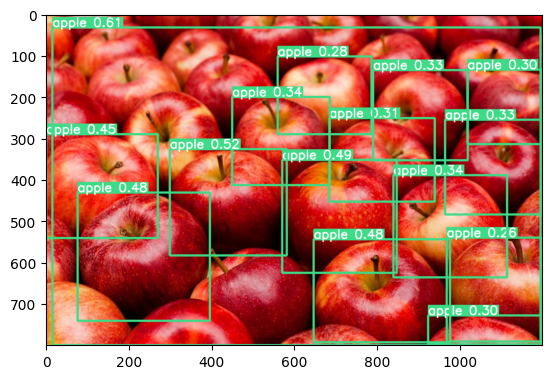

In [4]:
results_1 = yolo_model("https://storage.googleapis.com/648010c1-f244-4641-98f2-73ff6c1b4e99/ai_assignment_20230726_count.jpeg")
plt.imshow(results_1[0].plot()[:,:,::-1]) # swap BGR to RGB
plt.show()


100%|██████████| 279k/279k [00:00<00:00, 327kB/s]
image 1/1 /content/ai_assignment_20230726_classify.jpeg: 512x640 18 apples, 3 oranges, 67.5ms
Speed: 3.0ms preprocess, 67.5ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)


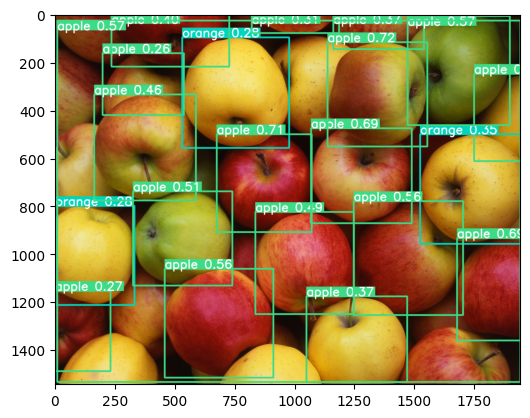

In [5]:
results_2 = yolo_model("https://storage.googleapis.com/648010c1-f244-4641-98f2-73ff6c1b4e99/ai_assignment_20230726_classify.jpeg")
plt.imshow(results_2[0].plot()[:,:,::-1]) # swap BGR to RGB
plt.show()

Therefore, we perform **fine-tuning** on the pretrained model in the hope of reaching a more satisfactory performance on this specific requirement of detecting apples.

We obtain a relevant (small) dataset from **Roboflow** by user `Lakshanta Dissanayake`.

There are other bigger datasets such as Object365 but within our limited computation budget, the small dataset is preferable.

In [6]:
!pip install roboflow

from roboflow import Roboflow

rf = Roboflow(api_key="___________") # input your own Roboflow api key
project = rf.workspace("lakshantha-dissanayake").project("apple-detection-5z37o")
dataset = project.version(1).download("yolov8", location="datasets/apple-detection-ld")

!mkdir apple-detection-ld
!cp datasets/apple-detection-ld/data.yaml apple-detection-ld/

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 10.9 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=6e9cfc77b4252a145e4436c32540322af377293b3fe4a0f15316e4a248f1c06d
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.0
    Uninstalling pyparsing-3.1.0:
      Su

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to datasets/apple-detection-ld in yolov8:: 100%|██████████| 1407/1407 [00:00<00:00, 2259.06it/s]


The final fine-tuned model which we found to be good when tested on the sample data is achieved through *multi-step* fine-tuning in order to avoid catasthropic forgetting. In particular, we eased in the objective function weighting so that the classification and balancing losses are considered at first, but then gradually only the bounding box loss is considered.

In [7]:
yolo_model.train(data='apple-detection-ld/data.yaml', epochs=500, patience=50, batch=64, imgsz=640, device=0)

New https://pypi.org/project/ultralytics/8.0.145 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.134 🚀 Python-3.10.6 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=apple-detection-ld/data.yaml, epochs=500, patience=50, batch=64, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None

In [8]:
yolo_model = YOLO("runs/detect/train/weights/last.pt")
yolo_model.train(data='apple-detection-ld/data.yaml', epochs=500, patience=100, batch=64, imgsz=640, device=0)

New https://pypi.org/project/ultralytics/8.0.145 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.134 🚀 Python-3.10.6 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=detect, mode=train, model=runs/detect/train/weights/last.pt, data=apple-detection-ld/data.yaml, epochs=500, patience=100, batch=64, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic

In [9]:
yolo_model = YOLO("runs/detect/train2/weights/best.pt")
yolo_model.train(data='apple-detection-ld/data.yaml', epochs=500, patience=100, batch=64, cls=0.1, dfl=0, box=9.9, imgsz=640, device=0)

New https://pypi.org/project/ultralytics/8.0.145 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.134 🚀 Python-3.10.6 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=detect, mode=train, model=runs/detect/train2/weights/best.pt, data=apple-detection-ld/data.yaml, epochs=500, patience=100, batch=64, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnosti

In [19]:
yolo_model = YOLO("runs/detect/train3/weights/best.pt")

If you rerun this whole notebook, the best model should be stored in `runs/detect/train3/weights/best.pt`. However, this would take about 1-2 hours, so if you want to skip the training process you can just use the models for inference using `count.ipynb`.